In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py 
import datetime
import glob
import copy
from calendar import monthrange
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [20]:
def compilealldatatarget(lats,lons,filelist,footprintradio,targetname1,targetname2):
    
    minlat = (min(lats)-footprintradio/110.0)
    maxlat = (max(lats)+footprintradio/110.0)
    minlon = (min(lons)-footprintradio/110.0)
    maxlon = (max(lons)+footprintradio/110.0)
    
    ilats = np.arange(int(maxlat)-int(minlat)+1,dtype=int)+int(minlat)
    ilons = np.arange(int(maxlon)-int(minlon)+1,dtype=int)+int(minlon)


    for ifile,filename in enumerate(filelist):
        datos = h5py.File(filename,'r')
        #print(ifile)
        for lat in ilats:
            for lon in ilons:
                #print(lat,lon)
                try:
                    gridname = '%iN%iW' % (lat,lon)
                    #print(gridname)
                    lt = datos[gridname]['lat'][()]
                    ln = datos[gridname]['lon'][()]
                    #print(ln)
                    tid = datos[gridname]['/Sounding/target_id'][()] 
                    tname = datos[gridname]['/Sounding/target_name'][()]
                    tidstr = tid.astype('U')
                    tnamestr = tname.astype('U')
                    mask = ((lt <= maxlat) & (lt >= minlat) & \
                           (ln <= maxlon) & (ln >= minlon) & \
                           ((tidstr == targetname1) | (tidstr == targetname2)))
                    #print(mask)
                    data_inter = datos[gridname][mask]
                    #print(data_inter)
                    
                    try:
                        data = np.append(data,data_inter)
                        #print('matrix exists')
                    except:
                        data = copy.copy(data_inter)
                        #print(data)
                        #print('new matrix')
                    print(data.shape)
                except:
                    print('exception: no dataset')
                #print 'data:',len(data)
                #print max(data['lat']), min(data['lat']), max(data['lon']), min(data['lon'])

        datos.close()
    #plt.plot(data['lon'],data['lat'],'.')
    #plt.show()
    return data


In [21]:
def datacorrection_ml(dset,data):
    
    cont = 0
    t0 = datetime.datetime.utcfromtimestamp(0.0)
    datacorr = copy.copy(data)
    print(data[name])
    for ii,ele in enumerate(dset['year']):
        
        try:
            tmin = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii],day=dset['day'][ii]-1,hour=0,minute=0,second=0)-t0).total_seconds()
        except:
            maxdays = monthrange(dset['year'][ii],dset['month'][ii]-1)
            tmin = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii]-1,day=monthrange,hour=0,minute=0,second=0)-t0).total_seconds()
        try:
            tmax = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii],day=dset['day'][ii]+1,hour=23,minute=59,second=59)-t0).total_seconds() 
        except:
            tmax = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii]+1,day=1,hour=23,minute=59,second=59)-t0).total_seconds()
        
        mask = (tmin <= data['tepoch']) & (tmax >= data['tepoch'])
      
        
        datacorr[name][mask] = (data[name][mask]*data[psurf][mask] - dset['xCO2altz'][ii]*dset['psurfaltz'][ii])/(data[psurf][mask]-dset['psurfaltz'][ii])
                
        cont = cont + len(data[name][mask])
        #print(len(data[name][mask]))
    print(cont)
    print("original data")
    print(data[name].shape)
    print(data[name])
    print("corrected")
    print(datacorr[name].shape)
    print(datacorr[name])
    return datacorr

In [22]:
def matrixcorrection_ml(dset,data,psurfmat):
    
    cont = 0
    t0 = datetime.datetime.utcfromtimestamp(0.0)
    datacorr = copy.copy(data)
    print(data[name])
    for ii,ele in enumerate(dset['year']):
        
        try:
            tmin = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii],day=dset['day'][ii]-1,hour=0,minute=0,second=0)-t0).total_seconds()
        except:
            maxdays = monthrange(dset['year'][ii],dset['month'][ii]-1)
            tmin = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii]-1,day=monthrange,hour=0,minute=0,second=0)-t0).total_seconds()
        try:
            tmax = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii],day=dset['day'][ii]+1,hour=23,minute=59,second=59)-t0).total_seconds() 
        except:
            tmax = (datetime.datetime(year=dset['year'][ii],month=dset['month'][ii]+1,day=1,hour=23,minute=59,second=59)-t0).total_seconds()
        
        mask = (tmin <= data['tepoch']) & (tmax >= data['tepoch'])
        print(len(datacorr[psurf][mask]))
        x=np.zeros((len(datacorr[psurf][mask])),dtype=np.float64)
        for jj,item in enumerate(datacorr[name][mask]):
            latcells = np.where(datacorr['lat'][mask][jj]>lats)
            loncells = np.where(datacorr['lon'][mask][jj]>lons)
            try:
                indexlon = loncells[0][-1]
            except:
                try:
                    indexlat = latcells[0][-1]
                    psurfval = psurfmat[0][indexlat]
                except:
                    psurfval = psurfmat[0][0]
            try:
                indexlat = latcells[0][-1]
                psurfval = psurfmat[indexlon][indexlat]
            except:
                psurfval = psurfmat[indexlon][0]
            
            a=data[name][mask][jj]*psurfval
            b=dset['xCO2altz'][ii]*dset['psurfaltz'][ii]
            c=psurfval-dset['psurfaltz'][ii]
            datacorr[name][mask][jj] = (data[name][mask][jj]*psurfval - dset['xCO2altz'][ii]*dset['psurfaltz'][ii])/(psurfval-dset['psurfaltz'][ii])
            x[jj] = (a-b)/c
            print(x[jj],datacorr[name][mask][jj],data[name][mask][jj])
        datacorr[name][mask] = x
        
        cont = cont + len(data[name][mask])
        #print(len(data[name][mask]))
    print(cont)
    print("original data")
    print(data[name].shape)
    print(data[name])
    print("corrected")
    print(datacorr[name].shape)
    print(datacorr[name])
    return datacorr

In [23]:
def makematrixfromcompileddata(lats,lons,data,name,footprintradio,flag):
    
    #print 'data:'
    #print max(data['lat']), min(data['lat']), max(data['lon']), min(data['lon'])
    matrix=np.zeros((len(lons),len(lats)),dtype=np.float64)
    countermatrix=np.zeros((len(lons),len(lats)),dtype=int)
    stdmatrix=np.zeros((len(lons),len(lats)),dtype=np.float64)
    for ilat,lat in enumerate(lats):
        for ilon,lon in enumerate(lons):
            distances2=np.array((data['lat']-lat)**2+(data['lon']-lon)**2)
            conditions=(footprintradio**2 > distances2)
            #print(conditions)
            index=np.where(conditions)[0]
            if len(index) > 0:
                vec=data[name][index]
                #print(vec)
                matrix[ilon,ilat]=np.average(vec)
                #print(matrix[ilon,ilat],ilon,ilat)
                stdmatrix[ilon,ilat]=np.std(vec)
                countermatrix[ilon,ilat]=len(vec)
            else:
                #print(matrix[ilon,ilat],ilon,ilat)
                pass
                #plt.plot(data['lon'],data['lat'],'b.')
                #plt.plot([lon],[lat],'ro')
                #plt.show()
    errmatrix=stdmatrix/np.sqrt(countermatrix)
    #print(matrix)
    if flag=='full':
        return matrix.T,stdmatrix.T, errmatrix.T
    else:
        return matrix.T


In [24]:
def matrixforinterval(tmin,tmax,dataorg,flag):
    index=np.where(np.logical_and(tmin <= dataorg['tepoch'],tmax >= dataorg['tepoch']))[0]
    data=dataorg[index]
    matrix,stdmat,errmat=makematrixfromcompileddata(lats,lons,data,name,footprintradio,flag)
    if flag=='full':
        return matrix,stdmat, errmat
    else:
        return matrix


In [25]:
def mapper3x2(title1,title2,fontsize,ticksize,lvls,matrices,figname,savefig):
    
    plt.figure(figsize=(20,30))
    for ii,matrix in enumerate(matrices):
        mxmap = plt.subplot(3, 2, ii+1, projection=ccrs.PlateCarree()) 
        mxmap.add_feature(cfeature.LAND)
        mxmap.add_feature(cfeature.OCEAN)
        mxmap.add_feature(cfeature.COASTLINE)
        mxmap.add_feature(cfeature.BORDERS, linestyle=':')
        mxmap.add_feature(cfeature.LAKES, alpha=0.5)
        mxmap.add_feature(cfeature.RIVERS)
        mxmap.add_feature(cfeature.STATES.with_scale('10m'))
        mxmap.set_extent((lonmin,lonmax,latmin,latmax))
        #mxmap.xaxis.set_visible(True)
        #mxmap.yaxis.set_visible(True)
    
        glines = mxmap.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        glines.xformatter = LongitudeFormatter()
        glines.yformatter = LatitudeFormatter()
        glines.top_labels = None
        glines.right_labels = None
        if (ii+1)%2==0:
            glines.left_labels = None
        glines.xlabel_style = {'size': 16}
        glines.ylabel_style = {'size': 16}
    
        plt.contourf(lons, lats, matrices[ii], levels = lvls[ii],cmap=plt.get_cmap("jet"),transform=ccrs.PlateCarree())
        if ii==0:
            plt.title(title1,size=fontsize)
        if ii==1:
            plt.title(title2,size=fontsize)
        if (ii==2) | (ii==3):
            plt.title('StDev Matrix',size=fontsize)
        if (ii==4) | (ii==5):
            plt.title('Error Matrix',size=fontsize)
        plt.xlabel("Longitude",size=fontsize)
        plt.ylabel("Latitude",size=fontsize)
        cbar= plt.colorbar(fraction=0.041, pad=.02)
        if (ii+1)%2 == 0:
            cbar.set_label("ppm", size=fontsize, labelpad=0.8)
        cbar.ax.tick_params(labelsize=ticksize)

    #plt.tight_layout()
    if savefig==1:
        plt.savefig(figname)
    plt.show()

In [26]:
def mapper3x3(titles,fontsize,ticksize,lvls,matrices,figname,savefig):
    
    plt.figure(figsize=(30,30))
    for ii,matrix in enumerate(matrices):
        mxmap = plt.subplot(3, 3, ii+1, projection=ccrs.PlateCarree()) 
        mxmap.add_feature(cfeature.LAND)
        mxmap.add_feature(cfeature.OCEAN)
        mxmap.add_feature(cfeature.COASTLINE)
        mxmap.add_feature(cfeature.BORDERS, linestyle=':')
        mxmap.add_feature(cfeature.LAKES, alpha=0.5)
        mxmap.add_feature(cfeature.RIVERS)
        mxmap.add_feature(cfeature.STATES.with_scale('10m'))
        mxmap.set_extent((lonmin,lonmax,latmin,latmax))
        #mxmap.xaxis.set_visible(True)
        #mxmap.yaxis.set_visible(True)
    
        glines = mxmap.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        glines.xformatter = LongitudeFormatter()
        glines.yformatter = LatitudeFormatter()
        glines.top_labels = None
        glines.right_labels = None
        if (ii!=0) & (ii!=3) & (ii!=6):
            glines.left_labels = None
        glines.xlabel_style = {'size': 16}
        glines.ylabel_style = {'size': 16}
    
        plt.contourf(lons, lats, matrices[ii], levels = lvls[ii],cmap=plt.get_cmap("jet"),transform=ccrs.PlateCarree())
        if ii==0:
            plt.title(titles[ii],size=fontsize)
        if ii==1:
            plt.title(titles[ii],size=fontsize)
        if ii==2:
            plt.title(titles[ii],size=fontsize)
        if (ii==3) | (ii==4) | (ii==5):
            plt.title('StDev Matrix',size=fontsize)
        if (ii==6) | (ii==7) | (ii==8):
            plt.title('Error Matrix',size=fontsize)
        plt.xlabel("Longitude",size=fontsize)
        plt.ylabel("Latitude",size=fontsize)
        cbar= plt.colorbar(fraction=0.041, pad=.02)
        if (ii+1)%3 == 0:
            cbar.set_label("ppm", size=fontsize, labelpad=0.8)
        cbar.ax.tick_params(labelsize=ticksize)

    #plt.tight_layout()
    if savefig==1:
        plt.savefig(figname)
    plt.show()

In [27]:
nx=50
ny=50

#latmin = 18.3
#latmax = 20.5
#lonmin = -100.5
#lonmax = -97.7
latmin = 19.1
latmax = 19.8
lonmin = -99.5
lonmax = -98.7
#latmin = 20
#latmax = 21
#lonmin = -104
#lonmax = -103
footprintradio = 10.0/110.0
pathname = 'd:\\CCA\\NASAGESDISC\\OCO3L2Lite\\mexico3\\mexico_oco3_lite_2020*.h5'
targetname1 = 'fossil0036'
targetname2 = 'volcano0002'
name = '/xco2'
psurf = '/Retrieval/psurf'
dsetpath = 'd:\\gitCCA\\cca-jupyter\\data\\sam_zmvm_altzbgrd.npz'

#paltz = 748.2134 #extended
#paltz = #no hay paltz en la matriz de psurf para el rango pequenyo
#xco2altz = 412.4
#psurfaltz = 633.72


In [28]:
to=datetime.datetime.utcfromtimestamp(0.0)

lats=latmin+(latmax-latmin)*np.arange(ny)/(ny-1)
lons=lonmin+(lonmax-lonmin)*np.arange(nx)/(nx-1)


lista=glob.glob(pathname)
#print(lista)

data = compilealldatatarget(lats,lons,lista,footprintradio,targetname1,targetname2)
print(data.shape)


(0,)
(0,)
(104,)
(342,)
(799,)
(1089,)
(1540,)
(1819,)
(2154,)
(2388,)
(2390,)
(2395,)
(2485,)
(2533,)
(2632,)
(2735,)
(2757,)
(2779,)
(2970,)
(3193,)
(3247,)
(3361,)
(3390,)
(3432,)
(3432,)


In [29]:
dset = np.load(dsetpath)
mset = np.load('Psurf_50x50_5km_SmallGrid.npz')
psurfmat = mset['matrix']
datos = datacorrection_ml(dset,data)
datac = matrixcorrection_ml(dset,data,psurfmat)

[414.06695557 414.81219482 413.70440674 ... 412.38046265 413.08029175
 412.85778809]
3027
original data
(3432,)
[414.06695557 414.81219482 413.70440674 ... 412.38046265 413.08029175
 412.85778809]
corrected
(3432,)
[460.19607138 467.47690543 453.68068618 ... 412.38046265 413.08029175
 412.85778809]
[414.06695557 414.81219482 413.70440674 ... 412.38046265 413.08029175
 412.85778809]
37
457.2124117039588 418.5391540527344 418.5391540527344
453.7834788732067 419.4197692871094 419.4197692871094
450.7802137504605 418.8149108886719 418.8149108886719
441.0059727160716 417.04095458984375 417.04095458984375
452.0068113311525 417.722412109375 417.722412109375
444.00401800957775 417.49652099609375 417.49652099609375
429.34908176290105 415.04931640625 415.04931640625
445.3676221264265 416.62567138671875 416.62567138671875
446.4339919546781 417.82958984375 417.82958984375
447.73539015768506 418.3058166503906 418.3058166503906
459.33682126178803 419.6055603027344 419.6055603027344
455.9085543788385 

387.3687576514833 405.93280029296875 405.93280029296875
389.00039438151566 406.1556701660156 406.1556701660156
389.53461465513357 406.2536315917969 406.2536315917969
384.02555727114924 405.2429504394531 405.2429504394531
401.91450847833846 408.9403991699219 408.9403991699219
397.10287874229783 408.1402587890625 408.1402587890625
400.19398666873576 408.3116455078125 408.3116455078125
397.95718604945694 407.85308837890625 407.85308837890625
398.1650068931852 407.93048095703125 407.93048095703125
398.8809456223611 407.961181640625 407.961181640625
392.939540724612 406.9912109375 406.9912109375
396.1870948665879 407.5096435546875 407.5096435546875
392.8328188549902 406.93988037109375 406.93988037109375
395.91970248348196 407.4856262207031 407.4856262207031
403.6652566262737 408.845947265625 408.845947265625
395.8110395112173 407.44720458984375 407.44720458984375
394.91948493789175 407.2983093261719 407.2983093261719
391.6220859415792 406.6837463378906 406.6837463378906
390.5968759678305 40

429.0072917971511 412.6890563964844 412.6890563964844
438.1158971891772 414.33709716796875 414.33709716796875
428.19751233790737 412.42645263671875 412.42645263671875
436.239826389543 413.9044189453125 413.9044189453125
440.6712323892791 414.7364807128906 414.7364807128906
435.8632023338577 413.9106140136719 413.9106140136719
432.29106338045347 413.3364562988281 413.3364562988281
440.6725263678141 414.85809326171875 414.85809326171875
437.8687518044204 414.3008728027344 414.3008728027344
430.66998085789874 413.0019226074219 413.0019226074219
415.59438600198126 410.2518615722656 410.2518615722656
432.92641447462745 413.3824768066406 413.3824768066406
433.547405216205 413.5377502441406 413.5377502441406
434.43662691780037 413.7530822753906 413.7530822753906
435.5581943888652 413.96044921875 413.96044921875
434.3090803471701 413.74542236328125 413.74542236328125
426.0511047415041 412.23028564453125 412.23028564453125
433.2896186626069 413.52276611328125 413.52276611328125
429.880201695580

436.3189507604433 414.91290283203125 414.91290283203125
432.64171384316967 414.1973571777344 414.1973571777344
434.27942106737 414.5144958496094 414.5144958496094
435.3800665535809 414.7281799316406 414.7281799316406
432.12661749393413 414.09503173828125 414.09503173828125
435.4749680790113 414.62255859375 414.62255859375
420.862052781605 411.52960205078125 411.52960205078125
432.66938389524296 413.5142822265625 413.5142822265625
422.75439500386955 411.9808654785156 411.9808654785156
427.6574874846404 412.5468444824219 412.5468444824219
436.8184717498626 413.50360107421875 413.50360107421875
429.48143854619667 412.3490905761719 412.3490905761719
429.12939666841464 412.1316833496094 412.1316833496094
449.5534199280153 414.1955871582031 414.1955871582031
423.1971416259606 411.9803161621094 411.9803161621094
438.44608679299057 413.6982421875 413.6982421875
432.00810827047326 412.824951171875 412.824951171875
461.4216651515929 416.4892883300781 416.4892883300781
465.1590270924668 416.72781

438.96647214097953 413.4542236328125 413.4542236328125
439.1361647731039 413.83685302734375 413.83685302734375
429.9709439030916 412.78375244140625 412.78375244140625
423.63506227192136 412.1041259765625 412.1041259765625
429.6825050245078 413.09307861328125 413.09307861328125
431.98078986778114 413.62591552734375 413.62591552734375
427.39607765246114 413.02777099609375 413.02777099609375
425.5831141500956 412.3939514160156 412.3939514160156
429.2415015194688 413.04937744140625 413.04937744140625
432.8866123345291 413.8996276855469 413.8996276855469
432.333564884585 413.9559326171875 413.9559326171875
419.80118884504 411.5091552734375 411.5091552734375
419.90016121659244 411.60040283203125 411.60040283203125
431.27848411896497 413.36962890625 413.36962890625
432.0446606666329 413.551025390625 413.551025390625
437.7531850747857 414.7555847167969 414.7555847167969
427.4541061912194 412.7689514160156 412.7689514160156
432.42203125098973 413.64129638671875 413.64129638671875
436.9958957337

430.6232381760689 414.0087585449219 414.0087585449219
432.3097455438173 414.29742431640625 414.29742431640625
433.8942101495535 414.59765625 414.59765625
433.0842537636098 414.45159912109375 414.45159912109375
429.3266559661581 413.7724609375 413.7724609375
433.6142306295518 414.5559997558594 414.5559997558594
438.7984697941511 415.5008544921875 415.5008544921875
426.7520705941214 413.3003234863281 413.3003234863281
433.6574343435581 414.5527038574219 414.5527038574219
431.90834242633446 414.23651123046875 414.23651123046875
432.48714624457534 414.34930419921875 414.34930419921875
433.7565253218645 414.57684326171875 414.57684326171875
424.53870379424427 412.8983459472656 412.8983459472656
426.429338946027 413.24468994140625 413.24468994140625
423.27279318861923 412.6695251464844 412.6695251464844
422.1059532892019 412.4565734863281 412.4565734863281
422.6760173382449 412.55865478515625 412.55865478515625
431.4896785213617 414.1688232421875 414.1688232421875
429.4821528023137 413.80166

428.7706298531304 413.65325927734375 413.65325927734375
425.70211883133084 413.0826110839844 413.0826110839844
428.922373951598 413.6346435546875 413.6346435546875
432.70611621404737 414.2569580078125 414.2569580078125
420.32058455355894 412.0710144042969 412.0710144042969
421.26842515541057 412.22332763671875 412.22332763671875
408.9334358375376 410.0629577636719 410.0629577636719
433.8327705024069 414.5718688964844 414.5718688964844
421.36926232519744 412.3070983886719 412.3070983886719
423.9517010215068 412.77569580078125 412.77569580078125
431.7714481964313 414.1910400390625 414.1910400390625
424.9180898077955 412.9288330078125 412.9288330078125
418.8979986772483 411.8458557128906 411.8458557128906
431.1359017348007 413.8970947265625 413.8970947265625
418.5920922769326 411.74249267578125 411.74249267578125
423.2764725515661 412.53582763671875 412.53582763671875
422.63393129901493 412.50457763671875 412.50457763671875
421.17122843925813 412.1492004394531 412.1492004394531
431.199507

433.5030601987843 414.80865478515625 414.80865478515625
431.0231210680487 414.38629150390625 414.38629150390625
427.9299980234456 413.7695617675781 413.7695617675781
430.4003787787344 414.0497741699219 414.0497741699219
425.0340927833052 413.23846435546875 413.23846435546875
428.9179846723797 413.83489990234375 413.83489990234375
435.6662731895875 414.9756774902344 414.9756774902344
432.66472080864366 414.27203369140625 414.27203369140625
470.20816551115405 414.7441101074219 414.7441101074219
471.69919320107334 414.75146484375 414.75146484375
443.33878904646883 413.3076171875 413.3076171875
434.15317360412365 412.8871765136719 412.8871765136719
438.50515224891996 413.26251220703125 413.26251220703125
442.3076925263772 413.91143798828125 413.91143798828125
427.9998924592212 412.4240417480469 412.4240417480469
431.5653109193484 412.63507080078125 412.63507080078125
441.658627142099 413.708984375 413.708984375
426.240542275446 412.1875915527344 412.1875915527344
444.6100780984392 413.5137

434.52069946357 414.83160400390625 414.83160400390625
429.8919048949869 414.03778076171875 414.03778076171875
428.04290867732396 413.70819091796875 413.70819091796875
428.1624650500778 413.7006530761719 413.7006530761719
430.8013504983275 414.0760192871094 414.0760192871094
416.803655110972 411.748291015625 411.748291015625
428.16632492541925 413.7337951660156 413.7337951660156
421.4332159502819 412.50018310546875 412.50018310546875
425.84931247155663 413.20953369140625 413.20953369140625
427.1001885288792 413.52288818359375 413.52288818359375
427.4338272627399 413.485595703125 413.485595703125
430.49572713692396 413.99554443359375 413.99554443359375
432.6200817677106 414.220947265625 414.220947265625
428.6207389849045 413.735107421875 413.735107421875
430.37385314799604 414.0351257324219 414.0351257324219
436.27985416636665 414.8148498535156 414.8148498535156
433.73794750801756 414.4303894042969 414.4303894042969
428.90594670921445 413.76556396484375 413.76556396484375
436.60858976011

443.2483394647742 416.2585754394531 416.2585754394531
435.11260902086207 415.220947265625 415.220947265625
443.7190808055176 416.5484924316406 416.5484924316406
431.406192675855 414.8404541015625 414.8404541015625
445.5993564787752 416.2879638671875 416.2879638671875
429.20827186734715 414.17449951171875 414.17449951171875
431.88264708336095 414.68798828125 414.68798828125
427.86065348935114 414.1732482910156 414.1732482910156
438.6726850373899 415.46875 415.46875
437.97550242832835 415.4924621582031 415.4924621582031
437.5496136556637 415.40728759765625 415.40728759765625
433.7102350902114 415.1102294921875 415.1102294921875
435.01209698271873 414.9731750488281 414.9731750488281
432.0342151873774 414.54913330078125 414.54913330078125
431.191598492288 414.4201354980469 414.4201354980469
440.6780097198482 415.18841552734375 415.18841552734375
432.1003841750499 414.20196533203125 414.20196533203125
432.2959065604742 414.256103515625 414.256103515625
426.3633561521751 413.4525451660156 41

430.1528914092859 414.835693359375 414.835693359375
426.63081883984955 414.20379638671875 414.20379638671875
434.53746605464767 415.6399230957031 415.6399230957031
431.5368861261747 415.1583557128906 415.1583557128906
428.5185268949434 414.4892578125 414.4892578125
433.2509960053469 415.3429260253906 415.3429260253906
429.0791904095721 414.6318054199219 414.6318054199219
430.1951333280885 414.8302001953125 414.8302001953125
427.56022334721354 414.4031982421875 414.4031982421875
431.24540092773043 414.84197998046875 414.84197998046875
429.7711385741595 414.6296081542969 414.6296081542969
425.5095405660023 413.9228210449219 413.9228210449219
431.12181151662105 414.88970947265625 414.88970947265625
430.66815318225565 414.83251953125 414.83251953125
423.6157546790962 413.3323974609375 413.3323974609375
437.214919304389 415.4364013671875 415.4364013671875
435.1712300453734 415.5083312988281 415.5083312988281
429.13132878352405 414.5472106933594 414.5472106933594
438.6082361269251 415.524627

396.9559427260504 409.2141418457031 409.2141418457031
417.22649404438084 412.50494384765625 412.50494384765625
412.58894361947085 411.739501953125 411.739501953125
412.2071164707965 411.669189453125 411.669189453125
410.8487913259278 411.46405029296875 411.46405029296875
416.8096423337246 412.3742370605469 412.3742370605469
418.7494395748067 412.7184753417969 412.7184753417969
415.3042428082402 412.1592102050781 412.1592102050781
418.867527018451 412.680419921875 412.680419921875
416.8965172181271 412.4218444824219 412.4218444824219
407.3539302613862 410.92218017578125 410.92218017578125
419.3017193813981 412.8009033203125 412.8009033203125
410.3553422585785 411.3702392578125 411.3702392578125
412.23041644449796 411.6777648925781 411.6777648925781
238
438.1776286139687 414.1372375488281 414.1372375488281
426.1105560457198 413.10577392578125 413.10577392578125
435.3134862823317 413.9563903808594 413.9563903808594
412.23018154231437 411.798095703125 411.798095703125
424.7183702656761 413

411.80446367305234 411.74359130859375 411.74359130859375
416.0325905839116 412.4820251464844 412.4820251464844
406.0989430043907 410.7433776855469 410.7433776855469
413.1759228484703 411.9838562011719 411.9838562011719
413.5249448935103 412.0540466308594 412.0540466308594
431.9958479189582 415.3796691894531 415.3796691894531
410.6095349967922 411.53057861328125 411.53057861328125
411.19179583988597 411.6335754394531 411.6335754394531
408.1795579804406 411.08770751953125 411.08770751953125
413.00666871704914 411.96173095703125 411.96173095703125
409.7584405797472 411.3733215332031 411.3733215332031
419.6390496073786 413.15985107421875 413.15985107421875
417.1078250511491 412.701171875 412.701171875
415.8306661510954 412.4722595214844 412.4722595214844
398.98814543544074 410.026123046875 410.026123046875
408.4091894657788 411.2198486328125 411.2198486328125
404.6117142393239 410.591064453125 410.591064453125
411.78332968319137 411.739013671875 411.739013671875
413.04652493522104 411.9442

411.71237603657914 410.27685546875 410.27685546875
404.50103169592506 409.0119323730469 409.0119323730469
400.32536213632653 408.2733154296875 408.2733154296875
401.37510470409904 408.4432067871094 408.4432067871094
403.067517958374 408.7542724609375 408.7542724609375
390.20383260890645 406.41436767578125 406.41436767578125
398.06847879491846 407.8689880371094 407.8689880371094
396.9222364025319 407.5830383300781 407.5830383300781
399.53335057473316 408.0841979980469 408.0841979980469
401.9200334365078 408.4894714355469 408.4894714355469
402.51252000809365 408.6037292480469 408.6037292480469
398.03736496886256 407.7971496582031 407.7971496582031
398.3202057814665 407.8519287109375 407.8519287109375
399.79526671585785 408.1434020996094 408.1434020996094
398.27227568036 407.83831787109375 407.83831787109375
398.92702465340983 407.9454040527344 407.9454040527344
399.7738739494525 408.1072998046875 408.1072998046875
390.860163831036 406.4755554199219 406.4755554199219
393.4293980443271 406

408.6374816894531 408.6374816894531 408.6374816894531
408.86688232421875 408.86688232421875 408.86688232421875
407.80474853515625 407.80474853515625 407.80474853515625
409.57708740234375 409.57708740234375 409.57708740234375
409.2355041503906 409.2355041503906 409.2355041503906
408.365234375 408.365234375 408.365234375
408.4067077636719 408.4067077636719 408.4067077636719
408.7806091308594 408.7806091308594 408.7806091308594
408.8421936035156 408.8421936035156 408.8421936035156
408.5772705078125 408.5772705078125 408.5772705078125
410.50848388671875 410.50848388671875 410.50848388671875
408.7381896972656 408.7381896972656 408.7381896972656
409.9319152832031 409.9319152832031 409.9319152832031
410.1968994140625 410.1968994140625 410.1968994140625
410.0638122558594 410.0638122558594 410.0638122558594
409.277099609375 409.277099609375 409.277099609375
409.37921142578125 409.37921142578125 409.37921142578125
408.61688232421875 408.61688232421875 408.61688232421875
409.984375 409.984375 409

In [30]:
tmintest=(datetime.datetime(2020,4,10,0,0,0)-to).total_seconds()
tmaxtest=(datetime.datetime(2020,4,12,0,0,0)-to).total_seconds()
masktest = (tmintest <= data['tepoch']) & (tmaxtest >= data['tepoch'])
datarowminus1 = 14
print(dset['xCO2altz'][datarowminus1],dset['psurfaltz'][datarowminus1])
datatest = copy.copy(data[masktest])
datatest[name] = (datatest[name]*datatest[psurf] - dset['xCO2altz'][datarowminus1]*dset['psurfaltz'][datarowminus1])/(datatest[psurf]-dset['psurfaltz'][datarowminus1])
print(datatest[name].shape)
print(datos[name][masktest].shape)
np.array_equal(datatest[name],datos[name][masktest])

410.6806284 639.4017546
(464,)
(464,)


True

In [31]:
datemin = datetime.datetime(2020,4,1,0,0,0)
datemax = datetime.datetime(2020,5,31,23,59,59)
tmin=(datemin-to).total_seconds()
tmax=(datemax-to).total_seconds()
flag='full'
matrix1,stdmat1,errmat1=matrixforinterval(tmin,tmax,data,flag)
matrix2,stdmat2,errmat2=matrixforinterval(tmin,tmax,datos,flag)
matrixc,stdmatc,errmatc=matrixforinterval(tmin,tmax,datac,flag)
mdiff = matrix2 - matrixc
stddiff = stdmat2 - stdmatc
errdiff = errmat2 - errmatc
#np.save('matrixDelta0605',matrix)

<ipython-input-23-eadd81ce8b84>:27: RuntimeWarning: invalid value encountered in true_divide
  errmatrix=stdmatrix/np.sqrt(countermatrix)


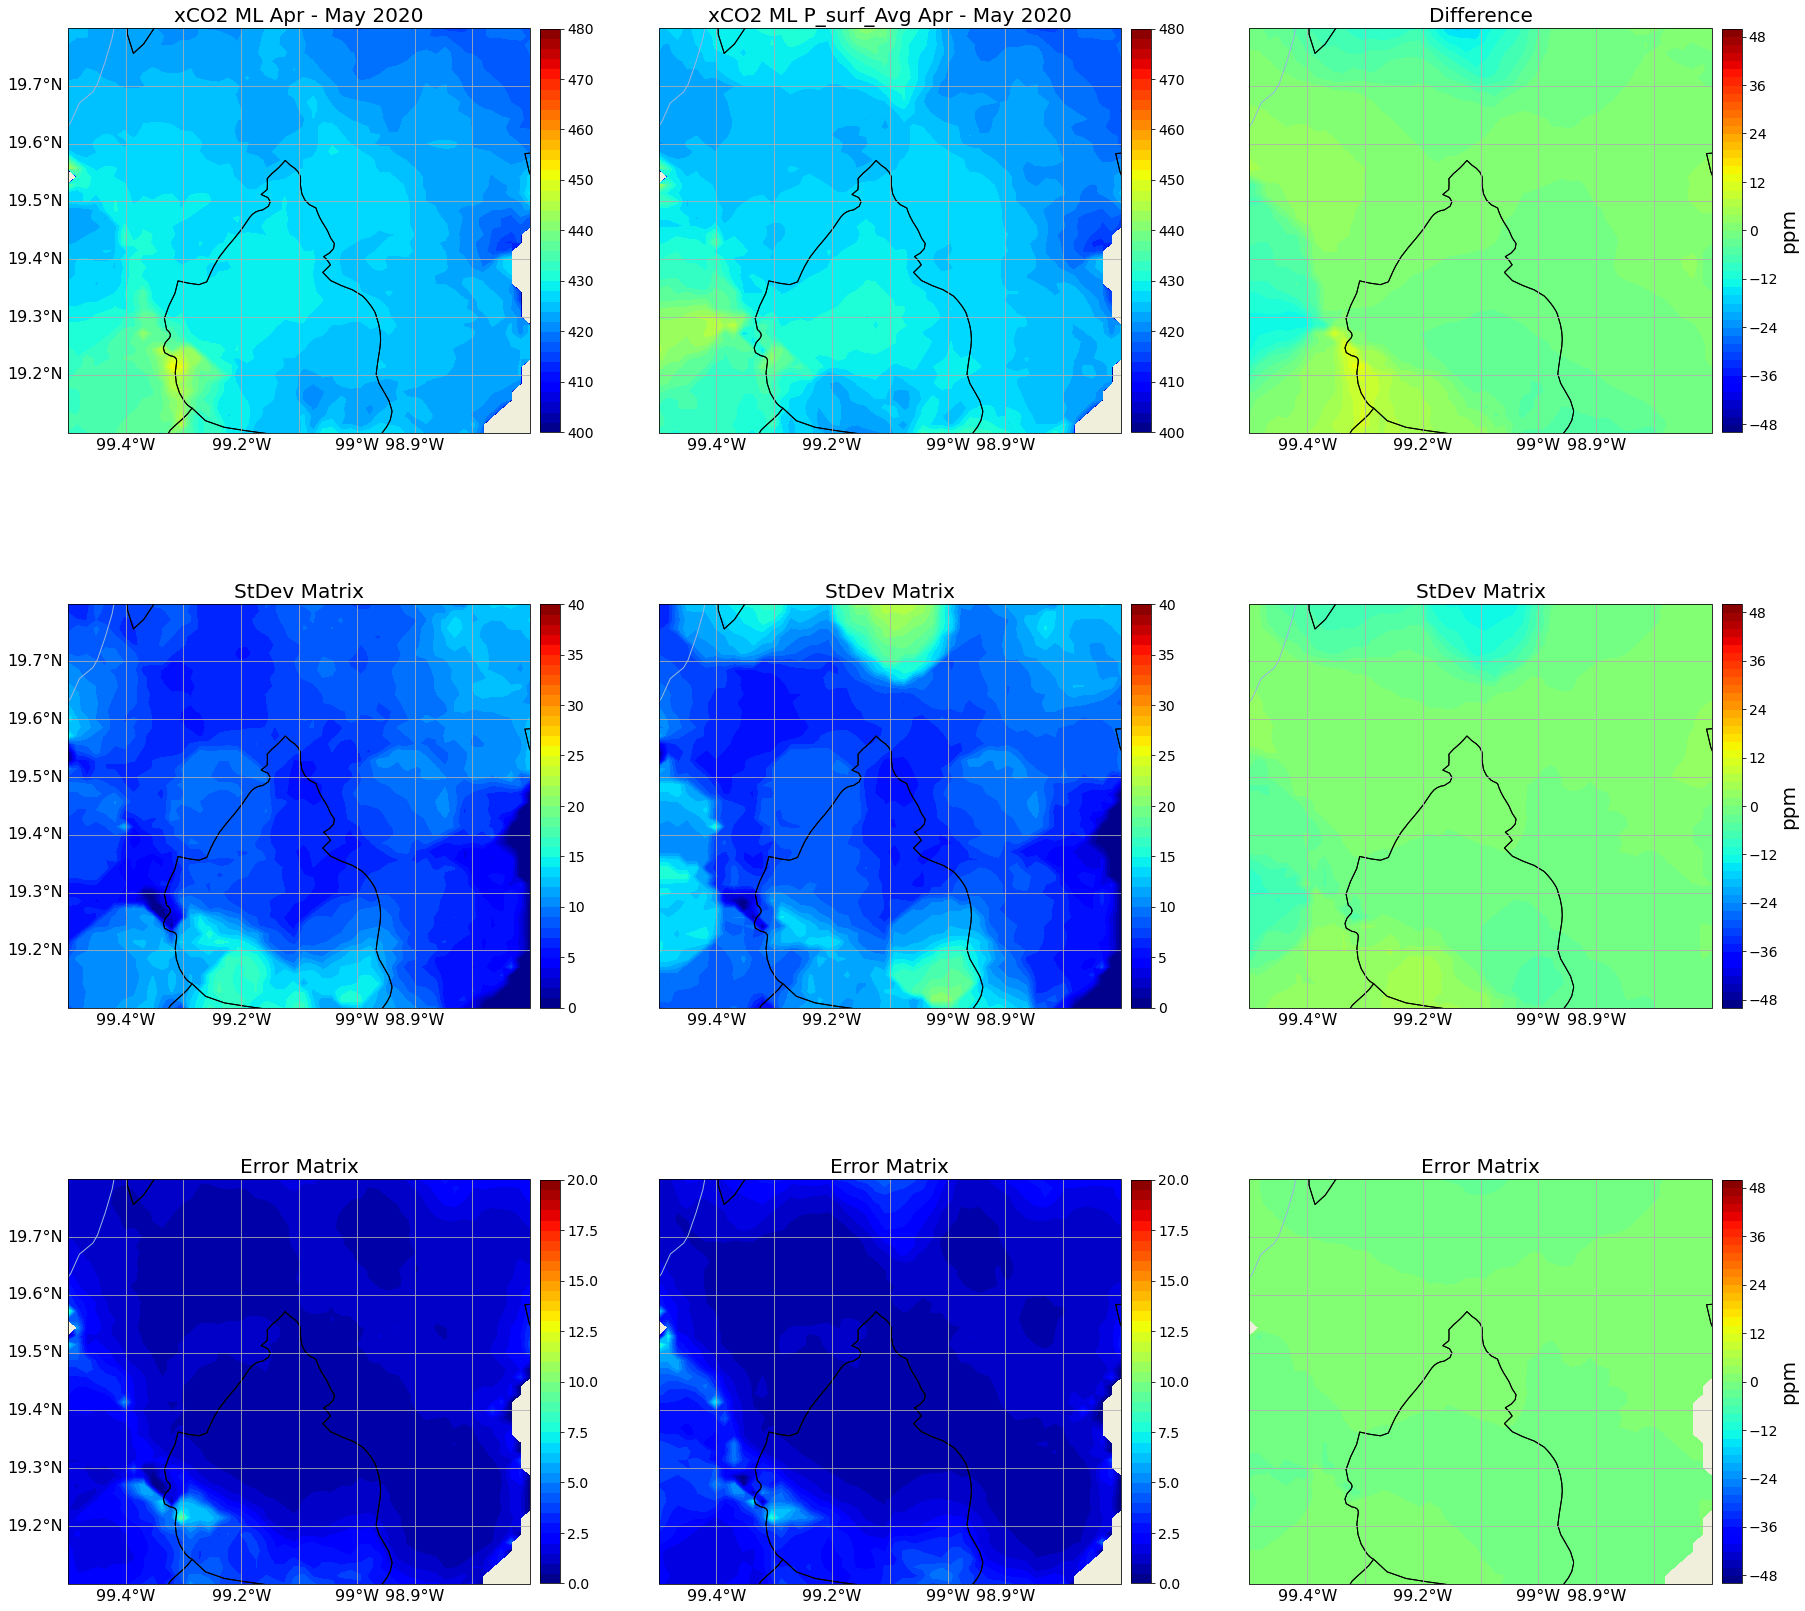

In [33]:
tyr= datemin.strftime("%Y")
if datemin.strftime("%b") == datemax.strftime("%b"):
    tmt= datemin.strftime("%b") + " "
else:
    tmt = datemin.strftime("%b") + ' - ' + datemax.strftime("%b") + " "
tdy=''
mldxco2 = 'P_surf_Avg '
title1 = 'xCO2 ML ' + tmt + tdy + tyr
title2 = 'xCO2 ML ' + mldxco2 + tmt + tdy + tyr
title3 = 'Difference'

fontsize = 20
ticksize = 14

lvls1 = np.arange(400,482,2)
lvls2 = np.arange(400,482,2)
lvls3 = np.arange(-50,52,2)
lvls4 = np.arange(0,41,1)
lvls5 = np.arange(0,41,1)
lvls6 = np.arange(-50,52,2)
lvls7 = np.arange(0,20.5,0.5)
lvls8 = np.arange(0,20.5,0.5)
lvls9 = np.arange(-50,52,2)

titles = [title1,title2,title3]
matrices = [matrix2,matrixc,mdiff,stdmat2,stdmatc,stddiff,errmat2,errmatc,errdiff]
lvls = [lvls1,lvls2,lvls3,lvls4,lvls5,lvls6,lvls7,lvls8,lvls9]

figname = 'f:\\gitCCA\\cca-jupyter\\figures\\3x3\\xCO2_ML_PsurfComp_B2_Small.png'
savefig = 0 # 0 for no 1 for yes
# Creates the map
##### NOTA, mapper usa plt.contourf() que jala las lats y lons de variables no incluidas en los argumentos!!!!
##### y de todas maneras funciona :O
mapper3x3(titles,fontsize,ticksize,lvls,matrices,figname,savefig)

In [165]:
##########################################################################################################

In [29]:
print(datac.shape,datos.shape)

(6607,) (6607,)


In [30]:
np.array_equal(data[name],datac[name])

True

In [32]:
print(matrixc)

[[  0.           0.         415.63543701 ...   0.           0.
    0.        ]
 [  0.           0.         415.63543701 ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.         411.42077637 ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


In [136]:
dset.close()
mset.close()